In [1]:
if "logger" in globals() and  len(logger.handlers) >= 1:
    # To suppress debug output from the logger defined in .ipython/profile_default/ipython_config.py
    logger.handlers.pop()

# Do not autoreload here b/c we need to pickle the ymodel method and it'll
# raise PicklingError: Can't pickle function: it's not the same object
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.output_html { display: block; margin-left: auto; margin-right: auto; }</style>"))

# Setup the model, the log likelihood, log prior, and log probability

We want fit the King (1966) model to the data where we believe the quoted 
uncertainties accurately capture the 'true' uncertainties, I guess. The first 
step is to write down the likelihood function (the probability of a dataset
given the model parameters). This is equivalent to describing the generative 
procedure for the data.

[Hogg, Bovy, Lang 2010](https://arxiv.org/pdf/1008.4686.pdf) 
> Imagine that the data *really do* come from the King model, and that the only
> reason that any data point deviates from this perfect, narrow, line  is  that
>  to  each  of  the  true $y$ values  a  small $y$-direction offset has been added,
>  where that offset was drawn from a Gaussian distribution of zero mean and known
>  variance $\sigma_y^2$.  In this model, given an independent position $x_i$, an 
>  uncertainty $\sigma_{yi}$, MLEs $W_0$, $M$, $r_t$, the frequency distribution
> $p(y_i \,| \, x_i, \sigma_{yi}, W_0, M, r_t)$ for $y_i$ is 

(equation 9, but for King model rather than linear fit)

$$
p(y_i \, | \, x_i, \sigma_{yi}, W_0, M, r_t) = \frac{1}{\sqrt{2 \pi \sigma_{yi}^2}}
    \exp \left( - \frac{[y_i - \text{King}(x_i, W_0, M, r_t)]^2}{2 \sigma_{yi}^2} \right)
$$

> which gives the expected frequency (in a hypothetical set of repeated experiments)
> of getting a value in the infinitesimal range $[y_i, y_i+ dy]$ per unit $dy$.
>
> The generative model provides us with a natural, justified, scalar objective: 
> We seek the parameters $W_0, M, r_t$ that maximize the probability of the
> observed data given the model or (in standard parlance) the *likelihood of 
> the  parameters*. In our generative model the data points are independently drawn
> (implicitly), so the likelihood $L$ is the product of conditional probabilities

$$
L = \Pi_{i=0}^N p(y_i \, | \, x_i, \sigma_{yi}, W_0, M, r_t) \quad .
$$ 

Taking the logarithm

$$ \ln L = \Sigma_{i=0}^N  \left[ -\frac{1}{2} \ln(2\pi \sigma_{yi}^2) -
    \frac{ \left[y_i - \text{King}(x_i, W_0, M, r_t) \,\right]^2}{2 \sigma_{yi}^2}  \right] \\
    = K - \frac{1}{2} \chi^2 \\
    = -\frac{1}{2} \Sigma_{i=0}^N  \left[ \frac{ \left[y_i - \text{King}(x_i, W_0, M, r_t) \,\right]^2}{\sigma_{yi}^2} 
        + \ln(2\pi \sigma_{yi}^2) \right]
$$

The last line shows the log likelihood in the [documention](https://emcee.readthedocs.io/en/stable/tutorials/line/#maximum-likelihood-estimation),
and the middle line above shows equation 11 in the paper to make the point that
likelihood maximization is identical to $\chi^2$ minimization.

The Bayesian generalization of this is saying that the the posterior equals 
the data times the prior normalised by the probability marginalised over all
fit parameters.

From the next section of the [documentation](https://emcee.readthedocs.io/en/stable/tutorials/line/#marginalization-uncertainty-estimation):

$$ 
p (W_0, M, r_t\,|\,x,y,\sigma) \propto p(W_0, M, r_t)\,p(y\,|\,x,\sigma, W_0, M, r_t) \quad .
$$

The likelihood function
$$ p(y|x, \sigma , W_0, M, r_t) $$

so the missing component is the "prior" function
$$ p(W_0, M, r_t) $$


In this example, we’ll use uniform (so-called "uninformative") priors on $W_0, M, and r_t$. For example, we'll use the following conservative priors

\begin{split}p(W_0) = \left \{\begin{array}{ll}
        \log_{10}(-\infty)? \,, & \mbox{if}\, 0 < W_0 < 14 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .\end{split}
    
\begin{split}p(M) = \left \{\begin{array}{ll}
        \log_{10}(-\infty)? \,, & \mbox{if}\, 2 < \log_{10}(W_0) < 6 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .\end{split}
    
\begin{split}p(r_t) = \left \{\begin{array}{ll}
        \log_{10}(-\infty)? \,, & \mbox{if}\, 1 < r_t < 300 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .\end{split}

Now the example in the documentation gives
```python
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
```

but this confuses me because it should be 
```python
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))
```

It should not matter that much, but te $2\pi$ in the normalisation of the Gaussian just disappeared.
I re-added it...


The interested reader should check out [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686) for a much more complete discussion of how to fit a line to data in The Real World™ and why MCMC might come in handy.

# First fit by minimize -log_likelihood

In [3]:
import sys
import numpy
import scipy
import logging
from matplotlib import pyplot

logging.getLogger("keyring").setLevel(logging.CRITICAL)
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)
logging.basicConfig(stream=sys.stdout, format="%(message)s")
logger = logging.getLogger(); logger.level = logging.INFO
for h in logger.handlers: h.setLevel(logger.level)

if "../src" not in sys.path: sys.path.insert(0, "../src")
from tlrh_profiles import (
    limepy_wrapper,
    minimise_chisq,
    run_mcmc,
    inspect_chains,
    get_tau,
    get_flat_samples,
    plot_results,
    plot_corner,
)
from gc_simulation import StarClusterSimulation

if "/supaharris" not in sys.path: sys.path.insert(0, "/supaharris")
from utils import parsec2arcmin

In [ ]:
sim = StarClusterSimulation(logger, "NGC 104")
sim.fit_model_to_deBoer2019(model="king", mcmc=False, verbose=True)
sim.fit_model_to_deBoer2019(model="wilson", mcmc=False, verbose=True)
sim.fit_model_to_deBoer2019(model="limepy", mcmc=False, verbose=True)
# sim.fit_model_to_deBoer2019(model="spes", mcmc=False, verbose=True)
# fig = plot_results(limepy_wrapper, sim, sim.fit_x, sim.fit_y, sim.fit_yerr, 
#     initial=sim.initial, ml=sim.soln.x)
# pyplot.show(fig)

In [123]:
sim.fit_model_to_deBoer2019(model="king", mcmc=False, verbose=True)

Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=8.475, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.475, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.475, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.475, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.475, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.554, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.554, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.554, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.554, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.554, M=1.078e+05, rt=40.102, g=1.000


Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=40.101, g=1.000


Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.701, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.682, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.682, g=1.000


Limepy, W0=8.581, M=1.078e+05, rt=39.794, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.794, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.794, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.794, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.703, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.751, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.721, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.721, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.721, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.721, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.721, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000


Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000


Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000


In [124]:
sim.fit_model_to_deBoer2019(model="wilson", mcmc=False, verbose=True)

Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=6.047, M=9.116e+04, rt=153.406, g=2.000
Limepy, W0=6.047, M=9.116e+04, rt=153.406, g=2.000
Limepy, W0=6.047, M=9.116e+04, rt=153.406, g=2.000
Limepy, W0=6.047, M=9.116e+04, rt=153.406, g=2.000
Limepy, W0=6.047, M=9.116e+04, rt=153.406, g=2.000
Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.058, M=9.116e+04, rt=153.538, g=2.000
Limepy, W0=7.058, M=9.116e+04, rt=153.538, g=2.000
Limepy, W0=7.058, M=9.116e+04, rt=153.538, g=2.000
Limepy, W0=7.058, M=9.116e+04, rt=153.538, g=2.000
Limepy, W0=7.058, M=9.116e+04, 

Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, 

Limepy, W0=7.197, M=9.116e+04, rt=188.389, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.389, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.367, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.367, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.367, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.367, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.367, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.356, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.356, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.356, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.356, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.356, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.351, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.351, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.351, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.351, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.351, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.348, g=2.000
Limepy, W0=7.196, M=9.116e+04, rt=188.349, g=2.000
Limepy, W0=7.196, M=9.116e+04, 

In [125]:
sim.fit_model_to_deBoer2019(model="limepy", mcmc=False, verbose=True)

Limepy, W0=8.308, M=1.030e+05, rt=55.739, g=1.336
Limepy, W0=8.308, M=1.030e+05, rt=55.739, g=1.336
Limepy, W0=8.308, M=1.030e+05, rt=55.739, g=1.336
Limepy, W0=8.308, M=1.030e+05, rt=55.739, g=1.336
Limepy, W0=8.308, M=1.030e+05, rt=55.739, g=1.336
Limepy, W0=8.308, M=1.030e+05, rt=55.739, g=1.336
Limepy, W0=8.496, M=1.030e+05, rt=55.767, g=0.344
Limepy, W0=8.496, M=1.030e+05, rt=55.767, g=0.344
Limepy, W0=8.496, M=1.030e+05, rt=55.767, g=0.344
Limepy, W0=8.496, M=1.030e+05, rt=55.767, g=0.344
Limepy, W0=8.496, M=1.030e+05, rt=55.767, g=0.344
Limepy, W0=8.496, M=1.030e+05, rt=55.767, g=0.344
Limepy, W0=8.310, M=1.030e+05, rt=55.739, g=1.327
Limepy, W0=8.310, M=1.030e+05, rt=55.739, g=1.327
Limepy, W0=8.310, M=1.030e+05, rt=55.739, g=1.327
Limepy, W0=8.310, M=1.030e+05, rt=55.739, g=1.327
Limepy, W0=8.310, M=1.030e+05, rt=55.739, g=1.327
Limepy, W0=8.310, M=1.030e+05, rt=55.739, g=1.327
Limepy, W0=8.308, M=1.030e+05, rt=55.739, g=1.334
Limepy, W0=8.308, M=1.030e+05, rt=55.739, g=1.334


Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390
Limepy, W0=8.247, M=1.030e+05, rt=60.564, g=1.390


In [126]:
sim.fit_model_to_deBoer2019(model="spes", mcmc=False, verbose=True)

Spes, W0=8.124, B=0.985, eta=0.157, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.10 seconds
Spes, W0=8.124, B=0.985, eta=0.157, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.09 seconds
Spes, W0=8.124, B=0.985, eta=0.157, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.08 seconds
Spes, W0=8.124, B=0.985, eta=0.157, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.09 seconds
Spes, W0=8.124, B=0.985, eta=0.157, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.08 seconds
Spes, W0=8.124, B=0.985, eta=0.157, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.08 seconds
Spes, W0=8.124, B=0.985, eta=0.157, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.08 seconds
Spes, W0=8.124, B=0.990, eta=0.158, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.09 seconds
Spes, W0=8.124, B=0.990, eta=0.158, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.08 seconds
Spes, W0=8.124, B=0.990, eta=0.158, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrappe

spes_wrapper took 0.09 seconds
Spes, W0=8.107, B=0.975, eta=0.213, M=1.018e+05, rt=41.534, nrt=63.184
spes_wrapper took 0.09 seconds
Spes, W0=8.107, B=0.975, eta=0.213, M=1.018e+05, rt=41.534, nrt=63.184
spes_wrapper took 0.09 seconds
Spes, W0=8.107, B=0.975, eta=0.213, M=1.018e+05, rt=41.534, nrt=63.184
spes_wrapper took 0.09 seconds
Spes, W0=8.039, B=0.971, eta=0.231, M=1.018e+05, rt=39.485, nrt=66.462
spes_wrapper took 0.09 seconds
Spes, W0=8.039, B=0.971, eta=0.231, M=1.018e+05, rt=39.485, nrt=66.462
spes_wrapper took 0.09 seconds
Spes, W0=8.039, B=0.971, eta=0.231, M=1.018e+05, rt=39.485, nrt=66.462
spes_wrapper took 0.09 seconds
Spes, W0=8.039, B=0.971, eta=0.231, M=1.018e+05, rt=39.485, nrt=66.462
spes_wrapper took 0.09 seconds
Spes, W0=8.039, B=0.971, eta=0.231, M=1.018e+05, rt=39.485, nrt=66.462
spes_wrapper took 0.09 seconds
Spes, W0=8.039, B=0.971, eta=0.231, M=1.018e+05, rt=39.485, nrt=66.462
spes_wrapper took 0.09 seconds
Spes, W0=8.039, B=0.971, eta=0.231, M=1.018e+05, rt

spes_wrapper took 0.09 seconds
Spes, W0=8.151, B=0.973, eta=0.214, M=1.018e+05, rt=40.483, nrt=64.824
spes_wrapper took 0.09 seconds
Spes, W0=8.151, B=0.973, eta=0.214, M=1.018e+05, rt=40.483, nrt=64.824
spes_wrapper took 0.09 seconds
Spes, W0=8.151, B=0.973, eta=0.214, M=1.018e+05, rt=40.483, nrt=64.824
spes_wrapper took 0.09 seconds
Spes, W0=8.151, B=0.973, eta=0.214, M=1.018e+05, rt=40.483, nrt=64.824
spes_wrapper took 0.09 seconds
Spes, W0=8.151, B=0.973, eta=0.214, M=1.018e+05, rt=40.483, nrt=64.824
spes_wrapper took 0.09 seconds
Spes, W0=8.151, B=0.973, eta=0.214, M=1.018e+05, rt=40.483, nrt=64.824
spes_wrapper took 0.09 seconds
Spes, W0=8.160, B=0.973, eta=0.216, M=1.018e+05, rt=40.239, nrt=65.218
spes_wrapper took 0.09 seconds
Spes, W0=8.160, B=0.973, eta=0.216, M=1.018e+05, rt=40.239, nrt=65.218
spes_wrapper took 0.08 seconds
Spes, W0=8.160, B=0.973, eta=0.216, M=1.018e+05, rt=40.239, nrt=65.218
spes_wrapper took 0.09 seconds
Spes, W0=8.160, B=0.973, eta=0.216, M=1.018e+05, rt

spes_wrapper took 0.09 seconds
Spes, W0=8.154, B=0.973, eta=0.215, M=1.018e+05, rt=40.418, nrt=64.928
spes_wrapper took 0.09 seconds
Spes, W0=8.154, B=0.973, eta=0.215, M=1.018e+05, rt=40.418, nrt=64.928
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.451, nrt=64.875
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.451, nrt=64.875
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.451, nrt=64.875
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.451, nrt=64.875
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.451, nrt=64.875
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.451, nrt=64.875
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.451, nrt=64.875
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt

Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.10 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.10 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.11 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.10 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrappe

spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.11 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.13 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt

spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.10 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.450, nrt=64.877
spes_wrapper took 0.09 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt

In [127]:
sim.fit

{'king': {'initial': [8.5820000000000007, 107803.319, 40.102170777162939],
  'fit_labels': ['W_0', 'M', 'r_t'],
  'model': <function gc_simulation.StarClusterSimulation.fit_model_to_deBoer2019.<locals>.<lambda>(x, W0, M, rt)>,
  'soln':       fun: 1492.8359562193039
   hess_inv: array([[  4.64053287e-07,  -7.02221593e-07,  -2.23056055e-05],
         [ -7.02221593e-07,   1.00001971e+00,   4.54337428e-04],
         [ -2.23056055e-05,   4.54337428e-04,   1.15990820e-02]])
        jac: array([ -1.26282333e+02,   1.80053711e-03,   6.69178772e+00])
    message: 'Desired error not necessarily achieved due to precision loss.'
       nfev: 924
        nit: 4
       njev: 182
     status: 2
    success: False
          x: array([  8.58077145e+00,   1.07803317e+05,   3.97752175e+01]),
  'mcmc_mle': [],
  'mcmc_err_up': [],
  'mcmc_err_down': [],
  'deB19_chi2': 4097.375},
 'wilson': {'initial': [7.0570000000000004,
   91163.149999999994,
   153.3858869617369],
  'fit_labels': ['W_0', 'M', 'r_t'],

Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
Limepy, W0=8.581, M=1.078e+05, rt=39.775, g=1.000
1510.653153 136 11.3582943835


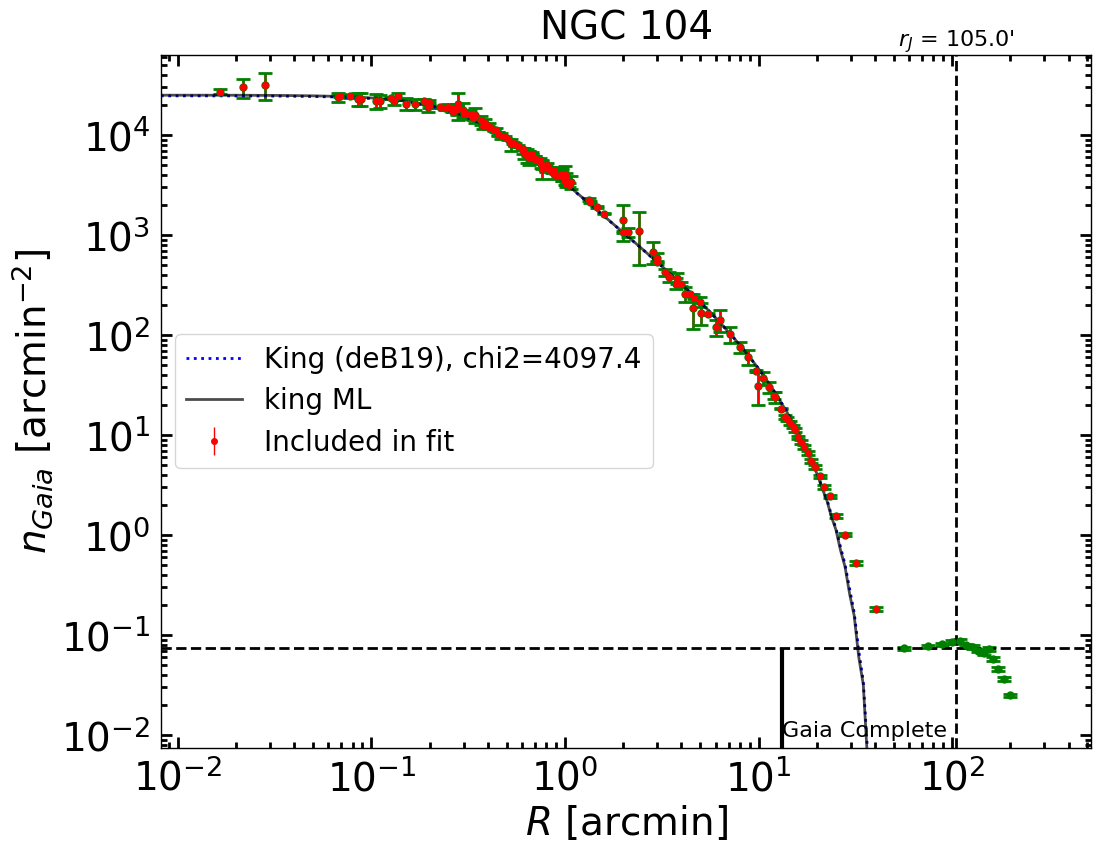

Limepy, W0=7.057, M=9.116e+04, rt=153.386, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
Limepy, W0=7.197, M=9.116e+04, rt=188.433, g=2.000
4773.57636803 136 35.8915516393


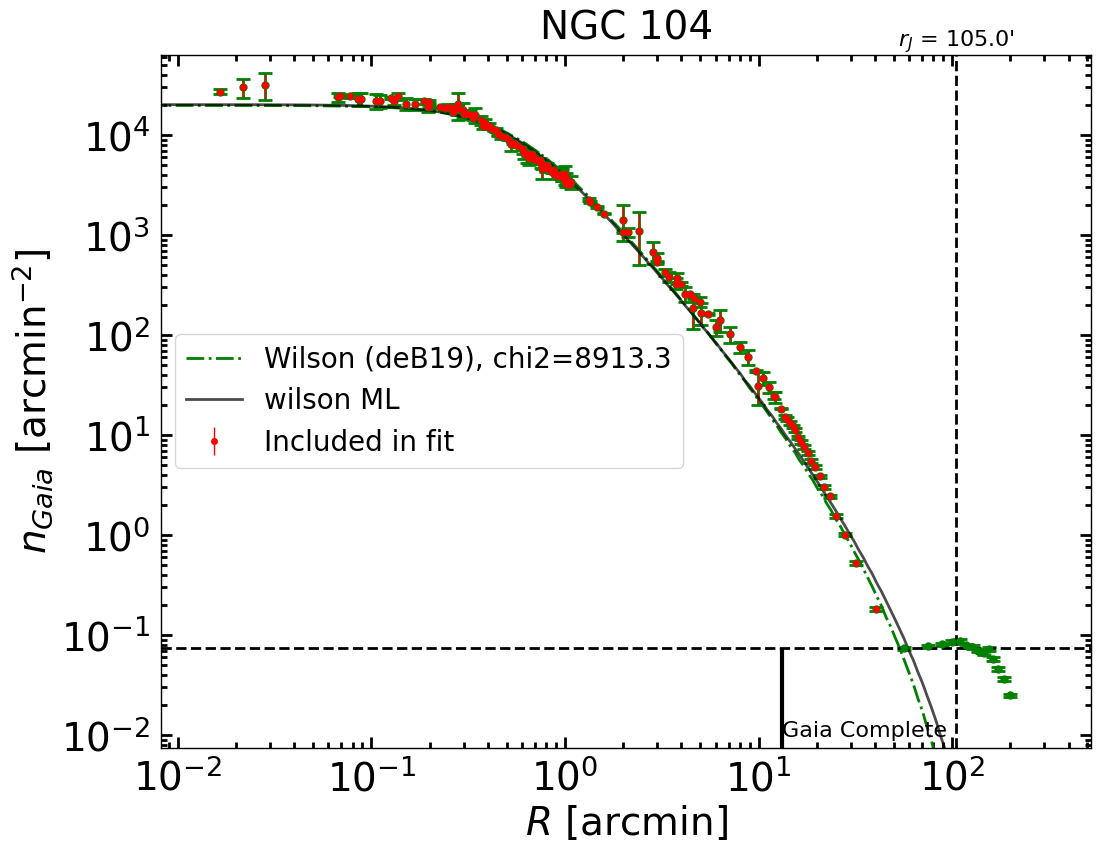

Limepy, W0=8.308, M=1.030e+05, rt=55.739, g=1.336
Limepy, W0=8.251, M=1.030e+05, rt=60.190, g=1.383
Limepy, W0=8.251, M=1.030e+05, rt=60.190, g=1.383
435.409982544 136 3.29856047382


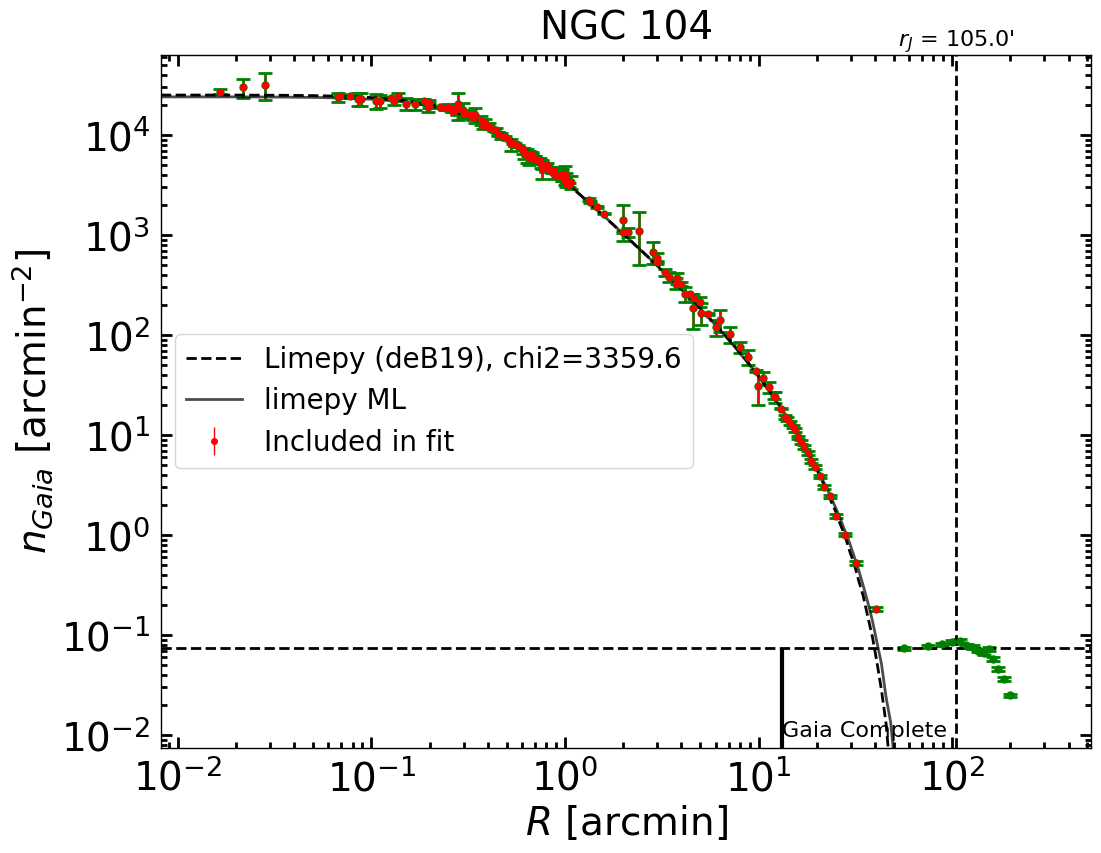

Spes, W0=8.124, B=0.985, eta=0.157, M=1.018e+05, rt=43.798, nrt=59.917
spes_wrapper took 0.10 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.451, nrt=64.875
spes_wrapper took 0.08 seconds
Spes, W0=8.152, B=0.973, eta=0.214, M=1.018e+05, rt=40.451, nrt=64.875
spes_wrapper took 0.09 seconds
492.447979714 136 3.75914488331


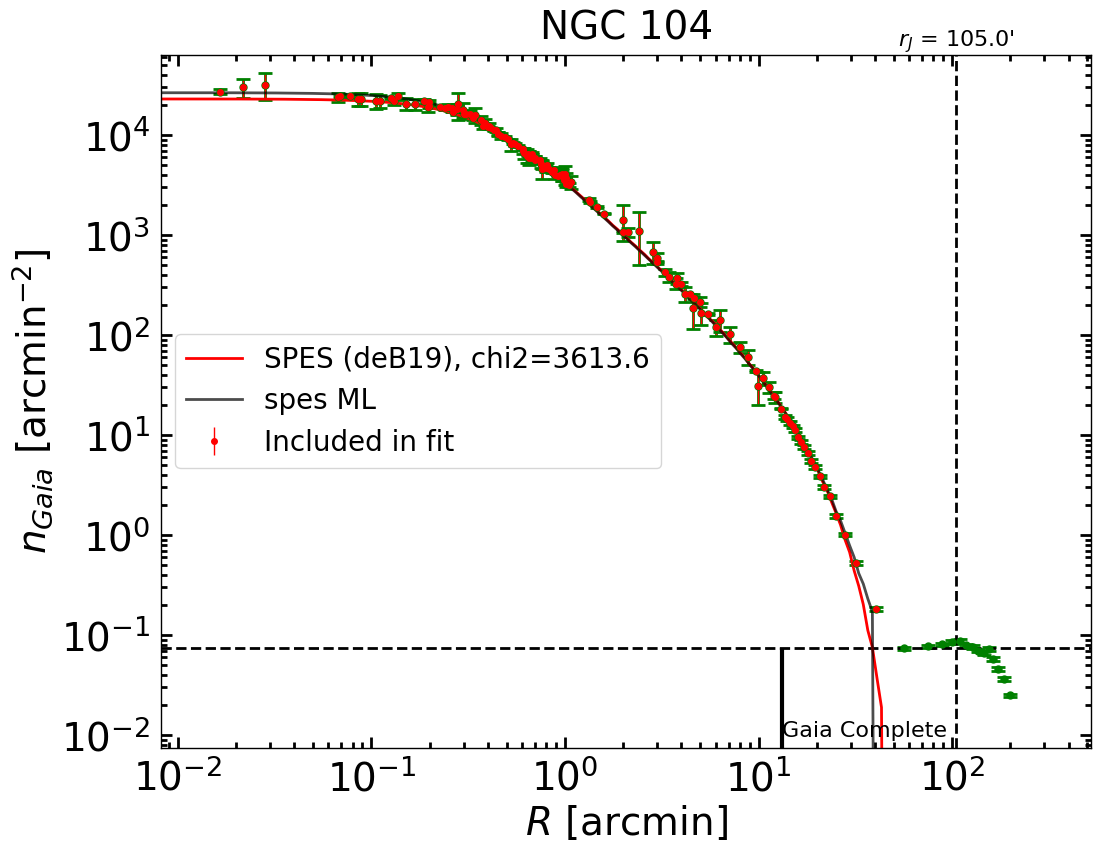

In [128]:
for model in ["king", "wilson", "limepy", "spes"]:
    pyplot.show(plot_results(sim, models=[model]))

# Now fit using emcee

In [4]:
sim = StarClusterSimulation(logger, "NGC 104")
sim.fit_model_to_deBoer2019(mcmc=True, Nwalkers=32, Nsamples=500, verbose=True)

Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=7.572, M=1.078e+05, rt=40.088, g=1.000
Limepy, W0=8.359, M=1.078e+05, rt=40.099, g=1.000
Limepy, W0=8.359, M=1.078e+05, rt=40.099, g=1.000
Limepy, W0=8.359, M=1.078e+05, rt=40.099, g=1.000
Limepy, W0=8.359, M=1.078e+05, rt=40.099, g=1.000
Limepy, W0=8.359, M=1.078e+05, rt=40.099, g=1.000
Limepy, W0=8.511, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.511, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.511, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.511, M=1.078e+05, rt=40.101, g=1.000
Limepy, W0=8.511, M=1.078e+05, rt=40.101, g=1.000


Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000


Maximum likelihood estimates for minimise_chisq:
  W_0 = 8.565
  M = 107803.317
  r_t = 39.755



AttributeError: Can't pickle local object 'StarClusterSimulation.fit_model_to_deBoer2019.<locals>.<lambda>'

# Inspect the chains

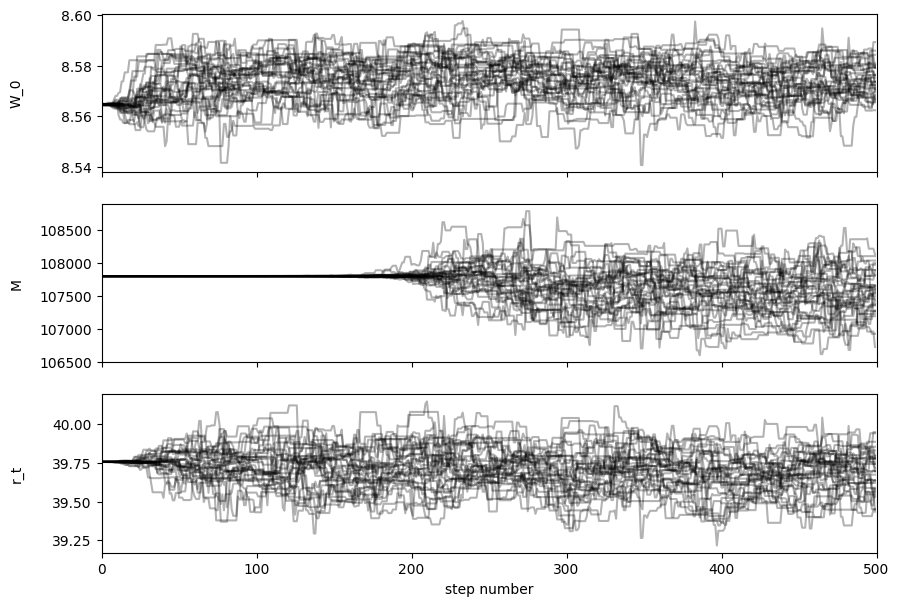

In [5]:
pyplot.style.use("default")
pyplot.show(inspect_chains(sim.sampler, sim.fit_labels))

The walkers start in small distributions around the maximum likelihood values
and then at some point wander and start exploring the full posterior distribution.
This only happens after 200 steps or so for M, so we should discard more samples.

# Inspect the MLEs 

This suggests that only about mean(tau) steps are needed for the chain to ''forget''
where it started. It’s not unreasonable to throw away a few times this number of 
steps as ''burn-in''. Let’s discard the initial 2.5 times mean tau steps, thin by about half
the autocorrelation time, and flatten the chain so that we have a flat list of samples

In [6]:
from tlrh_profiles import get_flat_samples
sim.flat_samples = get_flat_samples(sim.sampler, sim.tau, discard=300, thin=1)

discard: 300, thin: 1


Quantiles:
[(0.16, 8.565574460645303), (0.5, 8.5739208177516932), (0.84, 8.5812988802294807)]
Quantiles:
[(0.16, 107225.90360196547), (0.5, 107595.85713050833), (0.84, 107913.5368613484)]
Quantiles:
[(0.16, 39.544352354284854), (0.5, 39.694420213180152), (0.84, 39.820851534353118)]


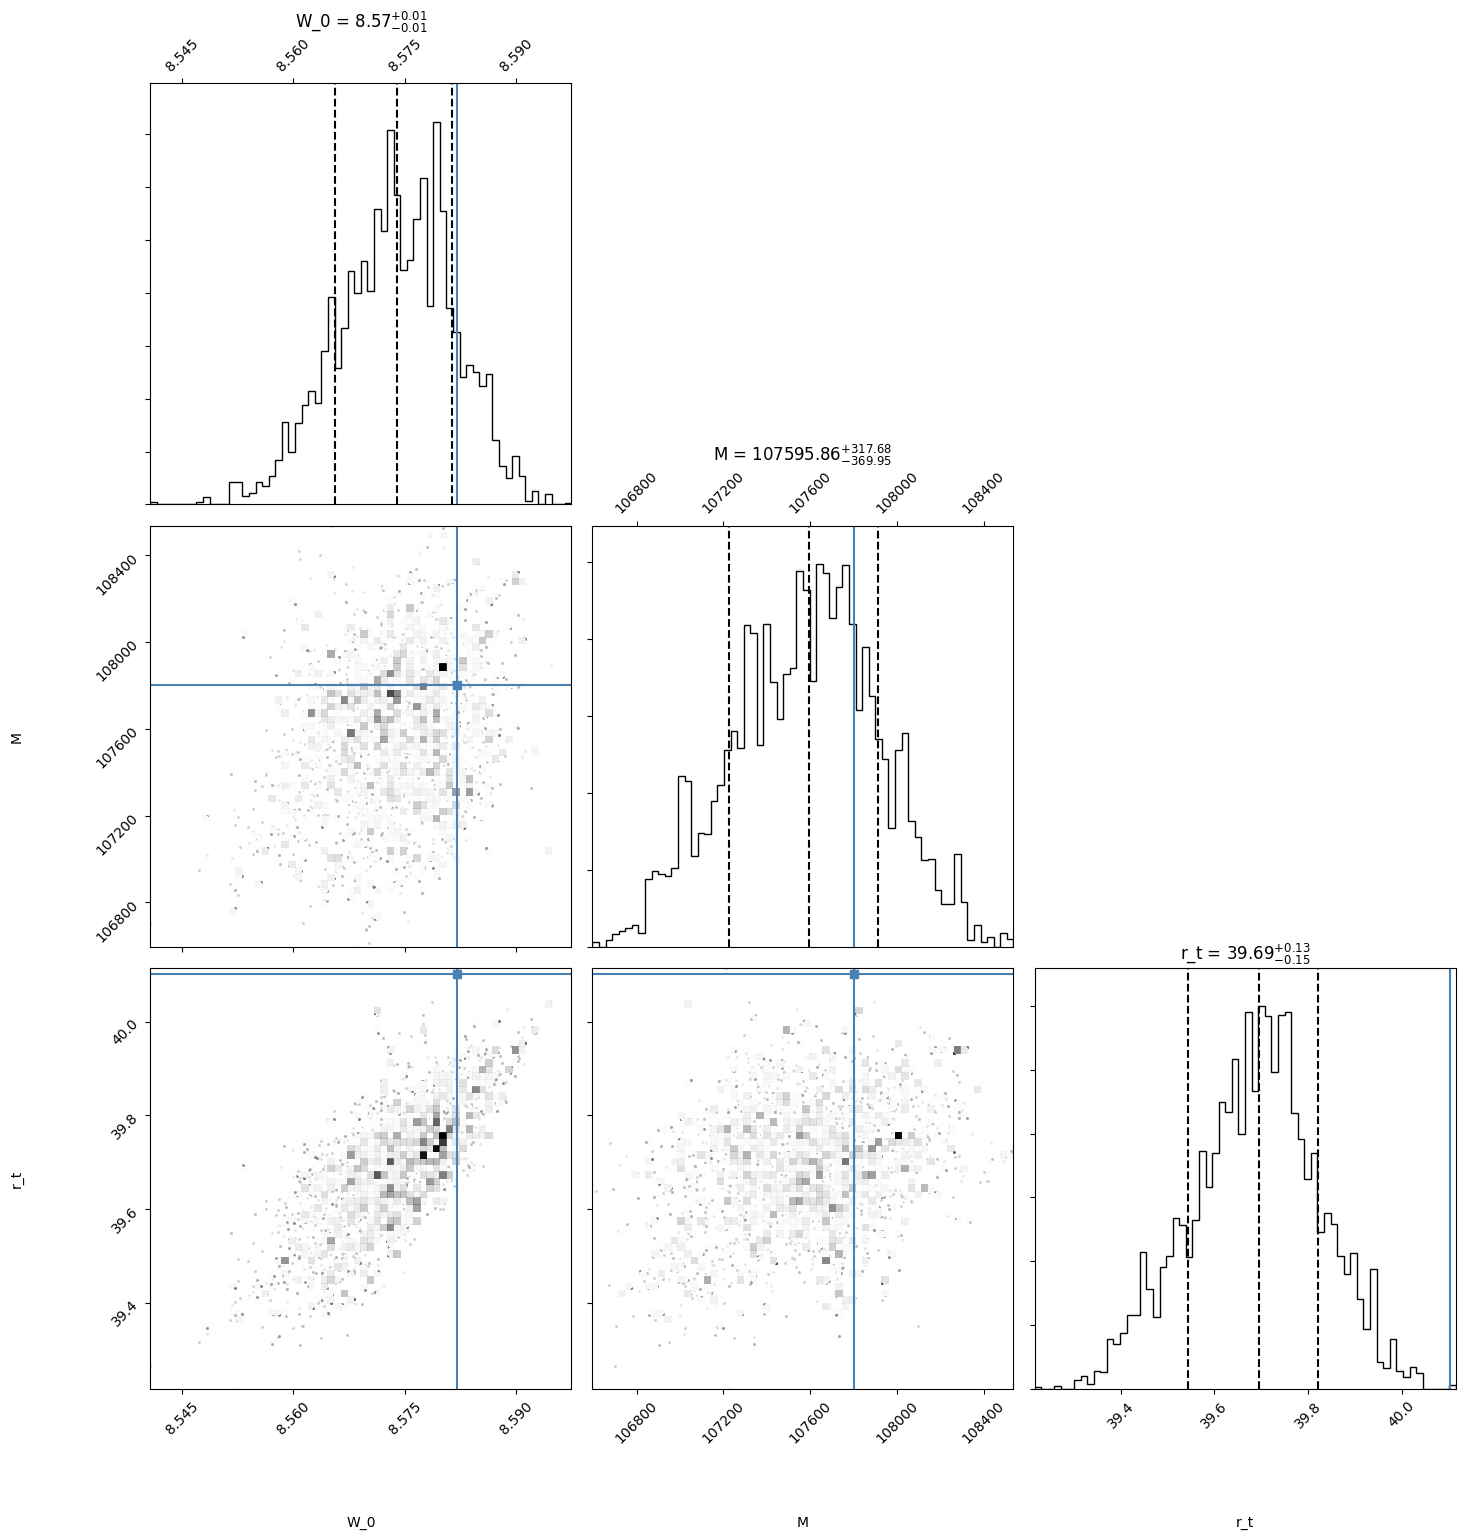

In [7]:
pyplot.style.use("default")
pyplot.show(plot_corner(sim.flat_samples, sim.initial, sim.fit_labels))

Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.575, M=1.078e+05, rt=39.712, g=1.000


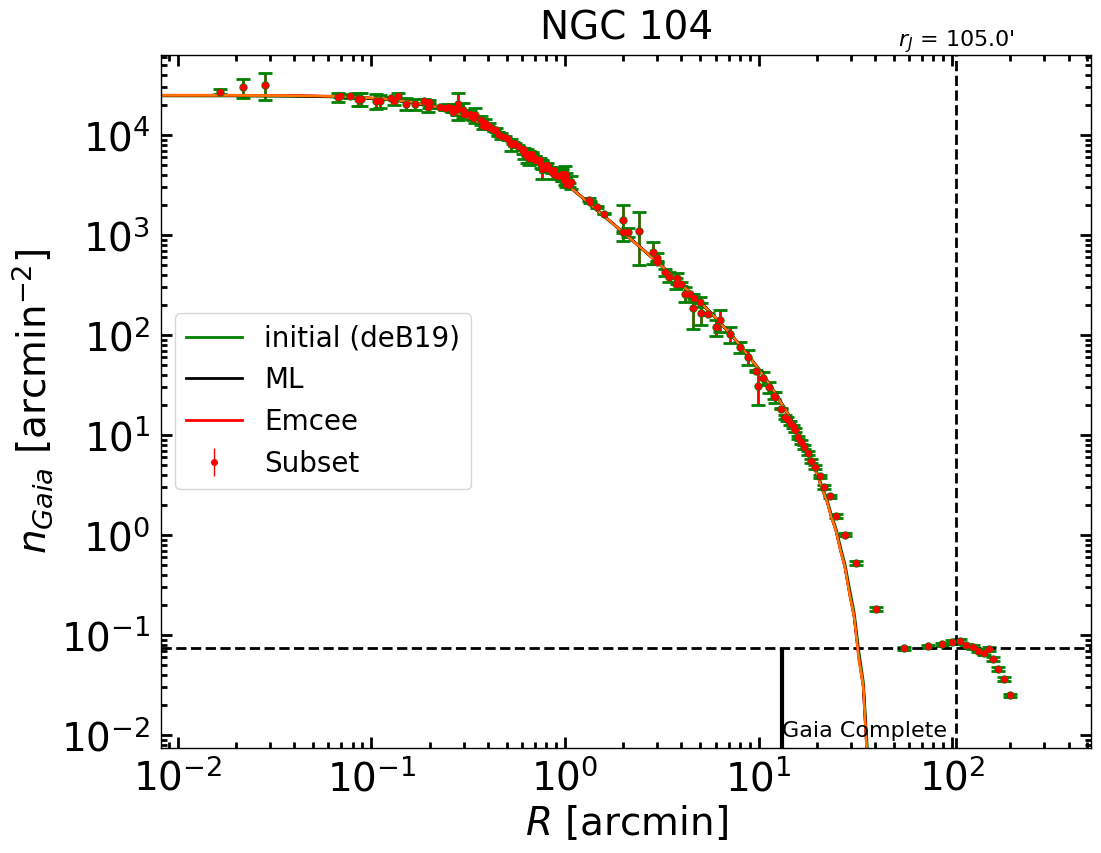

In [8]:
pyplot.style.use("tlrh")
pyplot.show(plot_results(limepy_wrapper, sim, sim.fit_x, sim.fit_y, sim.fit_yerr, 
    initial=sim.initial, ml=sim.soln.x, mcmc=sim.mcmc_mle, flat_samples=sim.flat_samples)
)

In [9]:
import pickle
with open("{0}{1}_{2}_{3}_{4}.p".format("/tidalshocks/out/",  "NGC 104", 32, 5000, 500), "rb") as f:
    sim = pickle.load(f)

Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.575, M=1.076e+05, rt=39.683, g=1.000


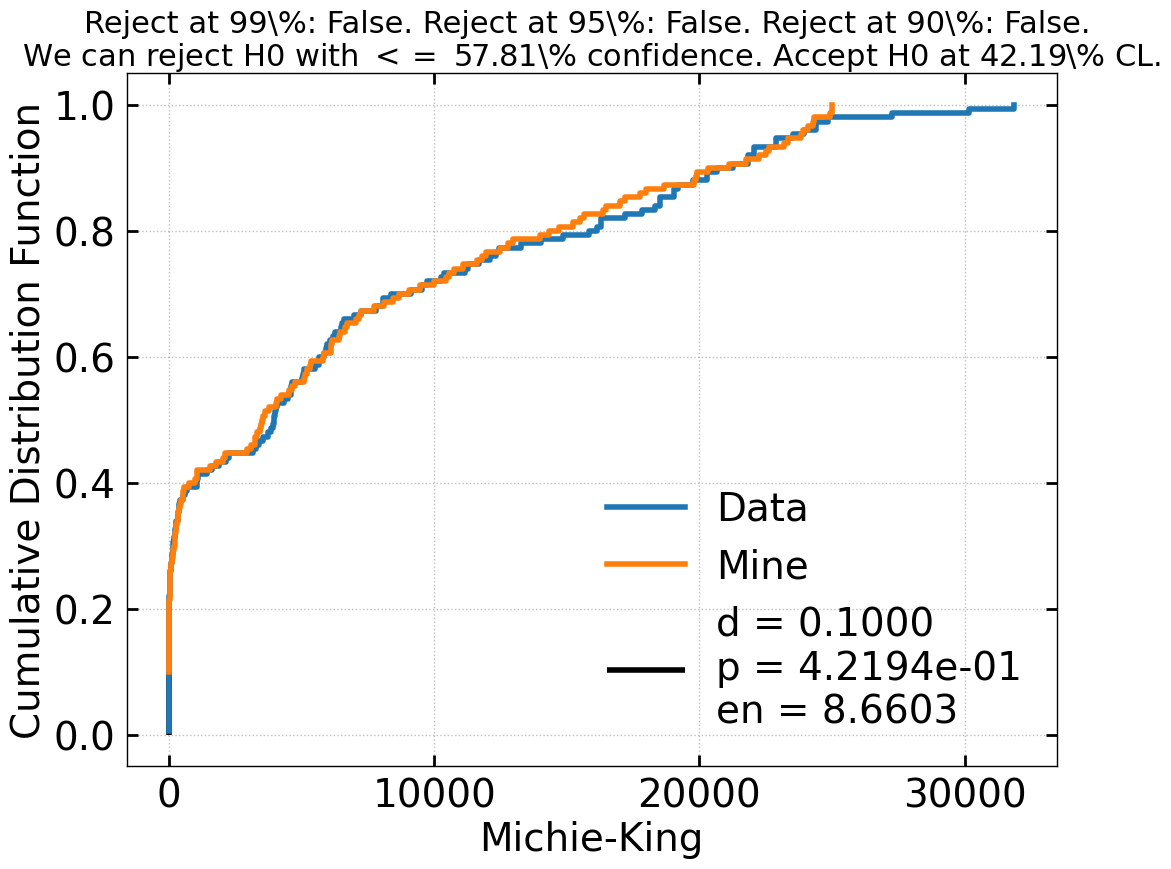

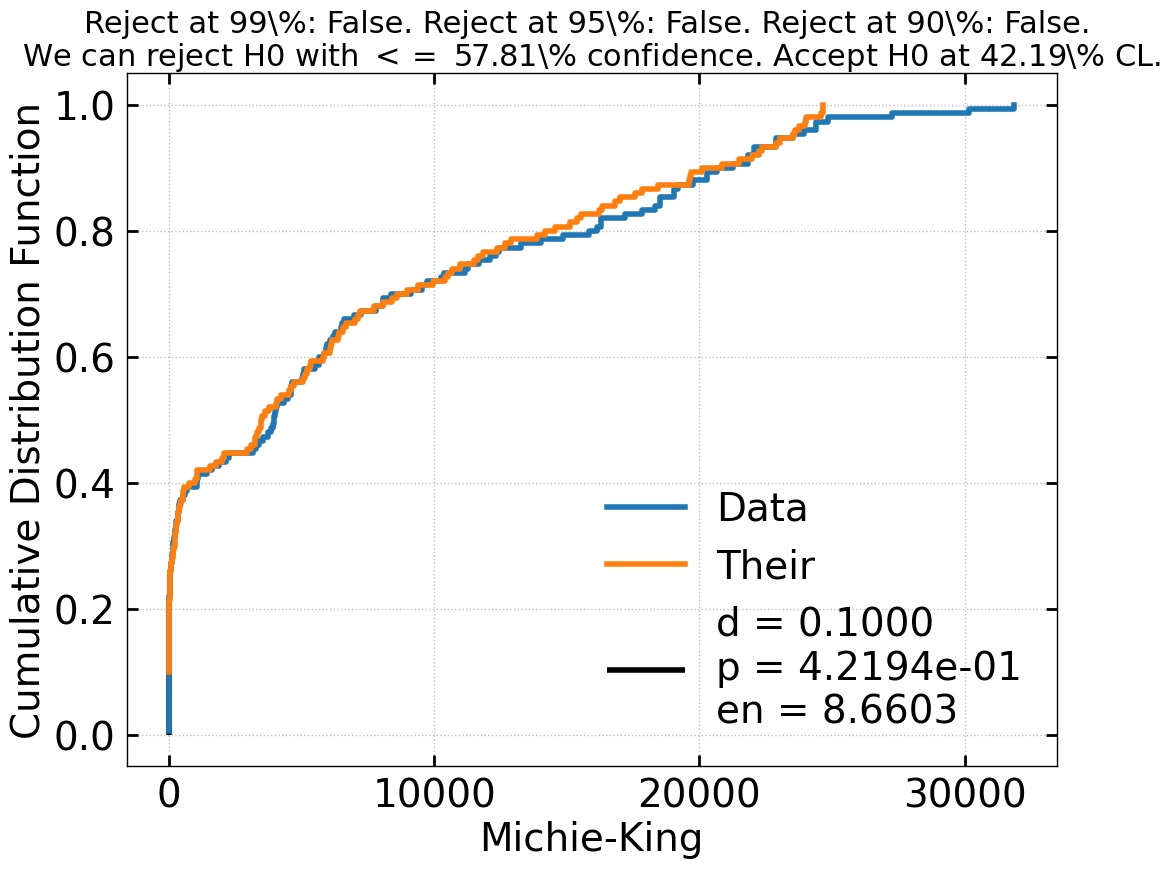

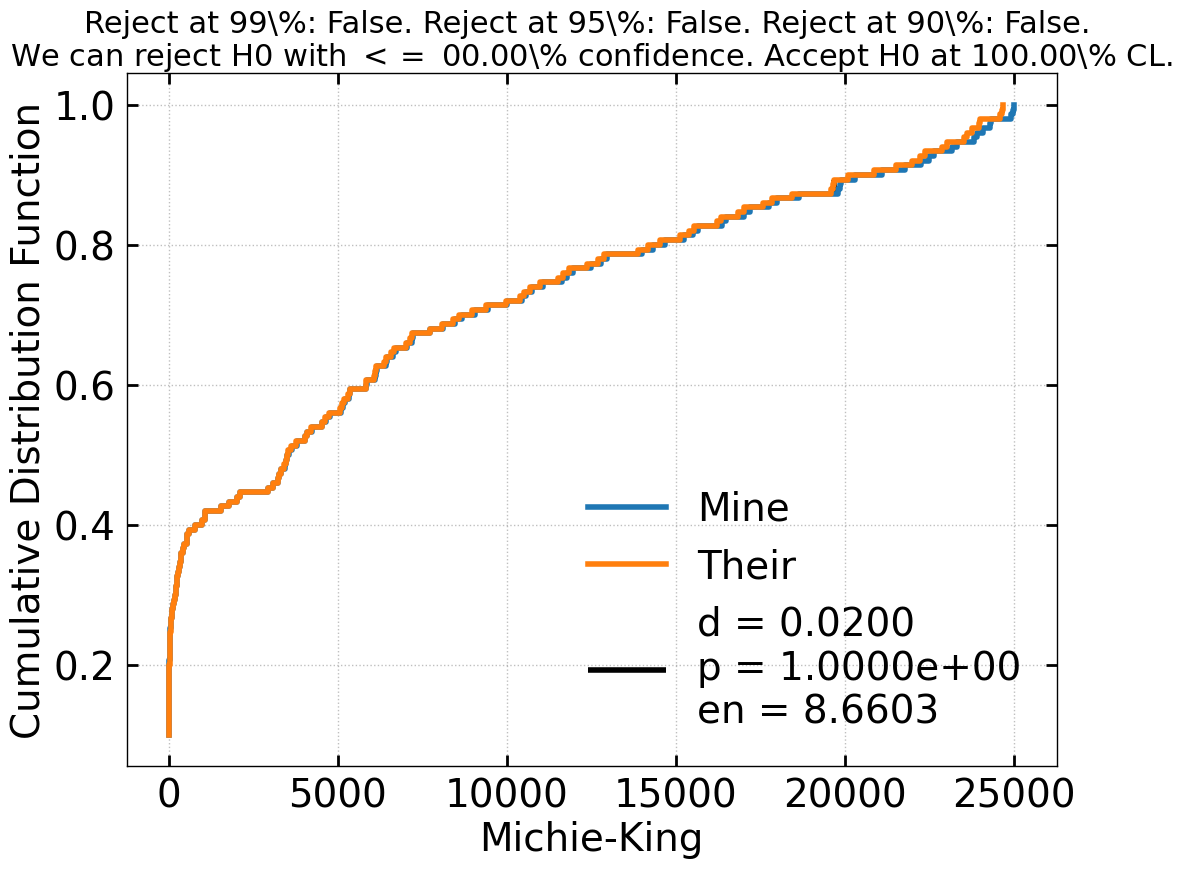

In [10]:
if "/auriga/src" not in sys.path: sys.path.insert(0, "/auriga/src")
from ks_test import ks_test
from ks_test import plot_ks_test

their  = limepy_wrapper(sim.fit_x, *sim.initial, verbose=True)
mine = limepy_wrapper(sim.fit_x, *sim.mcmc_mle, verbose=True)

xvals, n1, n2, cdf1, cdf2, d, dbin, en, prob = ks_test(sim.fit_y, mine)
pyplot.show(plot_ks_test(xvals, n1, cdf1, cdf2, d, dbin, en, prob, "Data", "Mine", "", "Michie-King"))

xvals, n1, n2, cdf1, cdf2, d, dbin, en, prob = ks_test(sim.fit_y, their)
pyplot.show(plot_ks_test(xvals, n1, cdf1, cdf2, d, dbin, en, prob, "Data", "Their", "", "Michie-King"))

xvals, n1, n2, cdf1, cdf2, d, dbin, en, prob = ks_test(mine, their)
pyplot.show(plot_ks_test(xvals, n1, cdf1, cdf2, d, dbin, en, prob, "Mine", "Their", "", "Michie-King"))